# ML - Fall 2023 - Practical - 2
## Practical Homework 2 - Naive Bayes

Student Number: 400105003

Student Name: Niki Sepasian




# Phase 0: Intro

**In this assignment, you will develop Naive Bayes models to perform text classification. The dataset contains texts and the feelings correspond to each text. Your goal is to make a model to predict the emotion associated with each given text.**

Importing necessary libraries

In [1]:
import nltk
import pandas
import sklearn
import string
import spacy
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [2]:
!pip install nltk

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.0
    Uninstalling en-core-web-sm-3.7.0:
      Successfully uninstalled en-core-web-sm-3.7.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!wget -O /kaggle/working/dataset.csv "https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1"

--2023-12-02 07:51:51--  https://www.dropbox.com/scl/fi/vezn3809mk6br6jb2xari/ML-P2-DataSet.csv?rlkey=yweu1fhtvisqhxm78s4ofpxed&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc6166603c124969d67d6093dc2.dl.dropboxusercontent.com/cd/0/inline/CIpFFbnN2oppJVkvoXBenQ1K2XsACROSc99QIWJj-83kXcPAnoXV25YxZktfQRh8l7jLsj7nTT2XnhQjYK6U3Ut0R1jhIA8fCjUaCalXcIxABbFoObiFwbWPIPbtkTp3v6betK5HX4-hz5RBXKhXI2A4/file?dl=1# [following]
--2023-12-02 07:51:52--  https://ucc6166603c124969d67d6093dc2.dl.dropboxusercontent.com/cd/0/inline/CIpFFbnN2oppJVkvoXBenQ1K2XsACROSc99QIWJj-83kXcPAnoXV25YxZktfQRh8l7jLsj7nTT2XnhQjYK6U3Ut0R1jhIA8fCjUaCalXcIxABbFoObiFwbWPIPbtkTp3v6betK5HX4-hz5RBXKhXI2A4/file?dl=1
Resolving ucc6166603c124969d67d6093dc2.dl.dropboxusercontent.com (ucc6166603c124969d67d6093dc2.dl.dropboxusercontent.com).

# Phase 1: Explore

## Sec 1: Load and Explore the given dataset **(P1-Sec1: 10 Points)**

Load the dataset. Look at the head of dataset. How many rows are there in the dataset? **(P1-1-1: 2 points)**




In [6]:
df= pd.read_csv("dataset.csv")
print(df.shape[0])
df.head(10)

5937


,Text,Feeling
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger
7,i finally fell asleep feeling angry useless an...,anger
8,i feel a bit annoyed and antsy in a good way,anger
9,i feel like i ve regained another vital part o...,joy


Handle missing values **(P1-1-2: 2 pints)**

In [7]:
print(df.isnull().sum())
# we have no missing values

Text       0
Feeling    0
dtype: int64


Identify the unique feeling values and for each of them, print their count in the dataset. **(P1-1-3: 2 points)**

In [8]:
labels= df['Feeling'].unique()
values=[];
for u in labels:
    count= df['Feeling'].value_counts()[u]
    print(u, ": ", count)
    values.append(count)
    

fear :  1937
anger :  2000
joy :  2000


Plot a pie chart to display the occurance frequency of each genre that you found in the prevoius part. **(P1-1-4: 2 points)**

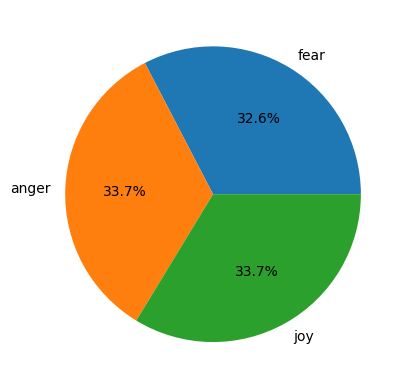

In [9]:
plt.pie(values, labels= labels, autopct='%1.1f%%')
plt.show() 

Find the mean, max and min values of the length (in chars) of the Text Column. **(P1-1-5: 2 points)**


In [10]:
from statistics import mean

lengths= df['Text'].apply(lambda x: len(x))
print("min: ",min(lengths))
print("max: ",max(lengths))
print("mean: ",mean(lengths))

min:  9
max:  298
mean:  97.42597271349166


# Phase 2: Preprocessing

## Sec 1: Preprocess the data **(P2-Sec1: 20 Points)**

In [11]:
class Preprocessor:

    def preprocess(self, text):
        text= text.lower()
        text= self.remove_links_and_tags(text)
        words= self.word_tokenize(text)
        words= self.remove_stopwords(words)
        words= self.remove_punctuations(words)
#         words= self.normalize(words)
        return words
        
    def remove_links_and_tags(self, text):
        return (re.sub('r`<.*?>', '', re.sub('r`http\S+','', text, flags= re.MULTILINE), flags= re.MULTILINE))

    def word_tokenize(self, text):
        return word_tokenize(text)

    def remove_stopwords(self, words):
        return [word for word in words if word not in stopwords.words('english')]

    def remove_punctuations(self, words):
        return [word.translate(str.maketrans('', '', string.punctuation)) for word in words]

    def normalize(self, words):
        spacy_model= spacy.load('en_core_web_sm')
        return [word.lemma_ for word in spacy_model(" ".join(words))]

Inspect the dataset for any empty cells or duplicate rows, and if they are present, remove the corresponding rows from the dataset. **(P2-1-1: 5 points)**

In [12]:
# althought we checked before that there are no empty cells
df= df.dropna()
df= df.drop_duplicates()

Clean the Texts by removing the special characters and punctations. **(P2-1-2: 5 points)**

In [13]:
preprocessor= Preprocessor()
df['processed_text']= df['Text'].apply(lambda x: preprocessor.remove_links_and_tags(x))
df['processed_text']= df['Text'].apply(lambda x: ' '.join(preprocessor.remove_punctuations(preprocessor.word_tokenize(x))))
df
# df['processed_text']= df['Text'].apply(lambda x: preprocessor.preprocess(x))
# df


,Text,Feeling,processed_text
0,i seriously hate one subject to death but now ...,fear,i seriously hate one subject to death but now ...
1,im so full of life i feel appalled,anger,im so full of life i feel appalled
2,i sit here to write i start to dig out my feel...,fear,i sit here to write i start to dig out my feel...
3,ive been really angry with r and i feel like a...,joy,ive been really angry with r and i feel like a...
4,i feel suspicious if there is no one outside l...,fear,i feel suspicious if there is no one outside l...
...,...,...,...
5932,i begun to feel distressed for you,fear,i begun to feel distressed for you
5933,i left feeling annoyed and angry thinking that...,anger,i left feeling annoyed and angry thinking that...
5934,i were to ever get married i d have everything...,joy,i were to ever get married i d have everything...
5935,i feel reluctant in applying there because i w...,fear,i feel reluctant in applying there because i w...


Remove the stop-words from the synopsis texts. Stop-words are those that have a high frequency in the language but don't have much information like 'the', 'and', 'to', etc. **(P2-1-3: 5 points)**

In [14]:
df['processed_text']= df['processed_text'].apply(lambda x: " ".join(preprocessor.remove_stopwords(x.split())))
df

,Text,Feeling,processed_text
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death feel reluctan...
1,im so full of life i feel appalled,anger,im full life feel appalled
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feelings think afraid acce...
3,ive been really angry with r and i feel like a...,joy,ive really angry r feel like idiot trusting fi...
4,i feel suspicious if there is no one outside l...,fear,feel suspicious one outside like rapture happe...
...,...,...,...
5932,i begun to feel distressed for you,fear,begun feel distressed
5933,i left feeling annoyed and angry thinking that...,anger,left feeling annoyed angry thinking center stu...
5934,i were to ever get married i d have everything...,joy,ever get married everything ready offer got to...
5935,i feel reluctant in applying there because i w...,fear,feel reluctant applying want able find company...


Tokenize the text and convert all characters to their lowercased version **(P2-1-4: 5 points)**

In [15]:
df['processed_text']= df['processed_text'].apply(lambda x: (preprocessor.word_tokenize(x.lower())))
df

,Text,Feeling,processed_text
0,i seriously hate one subject to death but now ...,fear,"[seriously, hate, one, subject, death, feel, r..."
1,im so full of life i feel appalled,anger,"[im, full, life, feel, appalled]"
2,i sit here to write i start to dig out my feel...,fear,"[sit, write, start, dig, feelings, think, afra..."
3,ive been really angry with r and i feel like a...,joy,"[ive, really, angry, r, feel, like, idiot, tru..."
4,i feel suspicious if there is no one outside l...,fear,"[feel, suspicious, one, outside, like, rapture..."
...,...,...,...
5932,i begun to feel distressed for you,fear,"[begun, feel, distressed]"
5933,i left feeling annoyed and angry thinking that...,anger,"[left, feeling, annoyed, angry, thinking, cent..."
5934,i were to ever get married i d have everything...,joy,"[ever, get, married, everything, ready, offer,..."
5935,i feel reluctant in applying there because i w...,fear,"[feel, reluctant, applying, want, able, find, ..."


# Phase 3: Training

## Sec 1: Preparing the training feed **(P3-Sec1: 20 Points)**

Extract the "X" and "y" numpy array from columns corresponding to text and feelings. **(P3-1-1: 5 Points)**

In [16]:
x= df["processed_text"].to_numpy()
print(x)
y= df["Feeling"].to_numpy()
print(y)

[list(['seriously', 'hate', 'one', 'subject', 'death', 'feel', 'reluctant', 'drop'])
 list(['im', 'full', 'life', 'feel', 'appalled'])
 list(['sit', 'write', 'start', 'dig', 'feelings', 'think', 'afraid', 'accept', 'possibility', 'might', 'make'])
 ...
 list(['ever', 'get', 'married', 'everything', 'ready', 'offer', 'got', 'together', 'go', 'clubs', 'even', 'perfect', 'good', 'looking', 'guys', 'feel', 'intimated', 'talking', 'clever', 'self'])
 list(['feel', 'reluctant', 'applying', 'want', 'able', 'find', 'company', 'know', 'least', 'one', 'person'])
 list(['wanted', 'apologize', 'feel', 'like', 'heartless', 'bitch'])]
['fear' 'anger' 'fear' ... 'joy' 'fear' 'anger']


Split the dataset into two parts such that the training set (denoted as `x_train` and ‍`y_train`) contains 80% of the samples. **(P3-1-2: 5 Points)**

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

Extract the text embeddings (feature vectors) for all the texts in the dataset. **(P3-1-3: 10 Points)**

For this task you can use **tf-idf** or **count vectorizer**. Search about them!

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf

tfidf= tf_idf(norm = None)
vectorized_x= tfidf.fit_transform(' '.join(t) for t in x).toarray()
vectorized_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(vectorized_x, y, test_size=0.2, shuffle=True)

## Sec 2: Naive Bayes from Scratch **(P3-Sec2: 20 Points)**

Complete this section with your code. **(P3-2: 20 points)**

In [20]:
from operator import itemgetter

class NaiveBayesClassifier:
    def __init__(self, alpha=1):

        '''
        Initialize these:

        Laplace smoothing parameter
        P(Y)
        P(X_i | Y)
        '''
        self.alpha=alpha
        self.y_prob= {}
        self.xy_prob= {}
        self.classes= None

    def fit(self, X, y):

        '''
        Calculate class probabilities P(Y)
        
        Calculate word probabilities P(X_i | Y)
        '''
      
        # calculate calss probabilities
        self.classes, class_count= np.unique(y, return_counts=True)
        total_count= len(y)
        for i in range(len(self.classes)):
            self.y_prob[self.classes[i]]= class_count[i]/total_count
        
        # calculate word probabilities
        for val in self.classes:
            indices= np.argwhere(y==val).flatten()
            N_xy= np.sum(X[indices], axis=0)
            N_y= np.sum(N_xy)
            n= X.shape[1]
            self.xy_prob[val]= ((N_xy+self.alpha)/(N_y+(self.alpha*n)))
            

    def predict(self, X):

        '''
        Calculate the log likelihood of the sample for each class

        Predict the class with the highest score
        '''

        results=[]
        for xi in X:
            prob=[]
        
            for val in self.classes:
                prior_log= np.log(self.y_prob[val])
                conditional_log= np.sum(xi*np.log(self.xy_prob[val]))
                prob.append((val, prior_log+conditional_log))
            
            results.append(max(prob, key=itemgetter(1))[0])
            
        return np.array(results).transpose()
            

## Sec 3: Fit models to the training data **(P3-Sec3: 10 Points)**

Fit a Naive Bayes classifier to the data. (Use both regressors - sklearn & from scratch) **(P3-3-1: 10 points)**

In [21]:
sklearn_model= MultinomialNB()
sklearn_model.fit(x_train, y_train)

MultinomialNB()

In [22]:
scratch_model= NaiveBayesClassifier()
scratch_model.fit(x_train, y_train)

# Phase 4: Evaluation

## Sec 1: Evaluate both models and compare the results (P4-Sec1: 20 points)

Predict the value of "y" for each "x" belonging to the "testing" set (use both models) **(P4-1-1: 5 points)**

In [23]:
sklearn_pred= sklearn_model.predict(x_test)
sklearn_pred

array(['fear', 'joy', 'joy', ..., 'anger', 'fear', 'fear'], dtype='<U5')

In [24]:
scratch_pred= scratch_model.predict(x_test)
scratch_pred

array(['fear', 'joy', 'joy', ..., 'anger', 'fear', 'fear'], dtype='<U5')

Compute Confusion matrix and classification report for each model **(P4-1-2: 10 points)**

In [25]:
from sklearn import metrics
print(classification_report(y_test, sklearn_pred))
print(metrics.confusion_matrix(y_test, sklearn_pred))

              precision    recall  f1-score   support

       anger       0.83      0.82      0.83       415
        fear       0.77      0.83      0.80       379
         joy       0.84      0.79      0.81       394

    accuracy                           0.81      1188
   macro avg       0.81      0.81      0.81      1188
weighted avg       0.82      0.81      0.81      1188

[[342  43  30]
 [ 37 315  27]
 [ 33  51 310]]


In [26]:
print(classification_report(y_test, scratch_pred))
print(metrics.confusion_matrix(y_test, scratch_pred))

              precision    recall  f1-score   support

       anger       0.83      0.82      0.83       415
        fear       0.77      0.83      0.80       379
         joy       0.84      0.79      0.81       394

    accuracy                           0.81      1188
   macro avg       0.81      0.81      0.81      1188
weighted avg       0.82      0.81      0.81      1188

[[342  43  30]
 [ 37 315  27]
 [ 33  51 310]]


Explain the results of the previous section (what is f1-score? - what is the recall? - what is precision?), also compare the model's performance **(P4-1-3: 5 points)**

* **Recall** is the total number of the actual positive cases that were predicted correctly. So recall is calculated as the number of true positives divided by the total number of true positives and false negatives

* **Precision** in definition is defined as the actual correct prediction divided by total prediction made by model. In simpler terms, it is a metric that tells us about the quality of positive predictions.

* **F1 Score** is a machine learning evaluation metric that measures a model's accuracy by calculating the weighted average of precision and recall. 

\* Compared to accuracy, F1 Score is a more useful way of understanding whether a model works good or not. The from-scartch model and sklearn model both have the same F1 score therefore they both have similar performances.

source: 
* [microsoft.com](https://learn.microsoft.com/en-us/dynamics365/finance/finance-insights/confusion-matrix#:~:text=Recall%20is%20the%20total%20number,TP%20%C3%B7%20(TP%20%2B%20FP))
* [linkedin.com](https://www.linkedin.com/pulse/confusion-matrix-accuracy-precision-recall-f1-score-measures-silwal/)
* [kdnuggets.com](https://www.kdnuggets.com/2022/11/confusion-matrix-precision-recall-explained.html#:~:text=Precision%20is%20a%20metric%20that,of%20true%20positives%20is%200.)

Model Performance Intuition Part: Now, you can test whether your model has a good prediction for a random text.

In [27]:
example= "Look! behind that tree there is a secret object, I am so scared"
processed= " ".join(preprocessor.preprocess(example))
print(scratch_model.predict(tfidf.transform([processed]).toarray()))

example= "I want to die"
processed= " ".join(preprocessor.preprocess(example))
print(scratch_model.predict(tfidf.transform([processed]).toarray()))

example= "I am so mad that I am thinking about ripping their vocal cords out"
processed= " ".join(preprocessor.preprocess(example))
print(scratch_model.predict(tfidf.transform([processed]).toarray()))

['anger']
['fear']
['anger']


# Phase 5: Neural Net (Bonus)

Make a list of words available in the dataset

In [28]:
df['get_words']= df['Text'].apply(lambda x: preprocessor.preprocess(x))

In [29]:
words=[]
for sen in df['get_words']:
    words.extend(sen)
    
# remove duplicate words
words=list(set(words))

Retrieve the Word2Vec embeddings for each word

In [30]:
import gensim
path= '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [31]:
texts= df['get_words']
embedded_text= [[w2v_model.key_to_index[word] for word in txt if word in w2v_model.key_to_index] for txt in texts]

In [32]:
one_hot_encoded_df= pd.get_dummies(data=df, columns=['Feeling'], dtype=int)
encoded_y= np.vstack((one_hot_encoded_df['Feeling_anger'], one_hot_encoded_df['Feeling_fear'], one_hot_encoded_df['Feeling_joy'])).T

x_train, x_test, y_train, y_test= train_test_split(embedded_text, encoded_y, test_size= 0.2)

Train a neural network consisting of LSTM and Fully-Connected layers to perform text classification **(P5-1: 8 points)**

Note: To get the points, Your neural net's performance should be at least as good as the Naive Bayes classifier. The exact architecture of the neural net is up to you. You can use Pytorch or Tensorflow to train it.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

vec= w2v_model.vectors
model= Sequential()
model.add(Embedding(input_dim= vec.shape[0], output_dim= vec.shape[1], input_length=15, weights=[vec], trainable=False))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(80, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

x_train= pad_sequences(x_train, maxlen=15)
x_test= pad_sequences(x_test, maxlen=15)
model.fit(x_train, y_train, epochs=10, callbacks=[early_stopping])

Epoch 1/10
149/149 [==============================] - 11s 36ms/step - loss: 0.9375 - accuracy: 0.5551
Epoch 2/10
149/149 [==============================] - 5s 35ms/step - loss: 0.6001 - accuracy: 0.7711
Epoch 3/10
149/149 [==============================] - 5s 35ms/step - loss: 0.4496 - accuracy: 0.8372
Epoch 4/10
149/149 [==============================] - 5s 35ms/step - loss: 0.3633 - accuracy: 0.8621
Epoch 5/10
149/149 [==============================] - 5s 35ms/step - loss: 0.3072 - accuracy: 0.8899
Epoch 6/10
149/149 [==============================] - 5s 35ms/step - loss: 0.2687 - accuracy: 0.9008
Epoch 7/10
149/149 [==============================] - 5s 35ms/step - loss: 0.2358 - accuracy: 0.9130
Epoch 8/10
149/149 [==============================] - 5s 34ms/step - loss: 0.2084 - accuracy: 0.9196
Epoch 9/10
149/149 [==============================] - 5s 34ms/step - loss: 0.2014 - accuracy: 0.9263
Epoch 10/10
149/149 [==============================] - 5s 35ms/step - loss: 0.1767 - accur

Evaluate the neural net on the training and testing data from the section *3-1-2*. **(P5-2: 2 points)**

In [34]:
y_pred= np.argmax(model.predict(x_test), axis= 1)
y_test= np.argmax(y_test, axis=1)     

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

38/38 [==============================] - 1s 9ms/step
[[389  18  16]
 [ 20 350  11]
 [  1  13 370]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       423
           1       0.92      0.92      0.92       381
           2       0.93      0.96      0.95       384

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



# Phase 6 (Optional): Submit your predictions to our Kaggle competition

Competition Link: WILL BE ADDED HERE

In [35]:
train= pd.read_csv("/kaggle/input/competition-files/train.csv")
test= pd.read_csv("/kaggle/input/competition-files/test.csv")

In [36]:
train['get_words']= train['Text'].apply(lambda x: preprocessor.preprocess(x))

In [37]:
import gensim
path= '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [38]:
texts= train['get_words']
x_train= [[w2v_model.key_to_index[word] for word in txt if word in w2v_model.key_to_index] for txt in texts]

In [39]:
one_hot_encoded_df= pd.get_dummies(data=train, columns=['target'], dtype=int)
y_train= np.vstack((one_hot_encoded_df['target_anger'], one_hot_encoded_df['target_fear'], one_hot_encoded_df['target_joy'])).T

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

vec= w2v_model.vectors
modelc= Sequential()
modelc.add(Embedding(input_dim= vec.shape[0], output_dim= vec.shape[1], input_length=15, weights=[vec], trainable=False))
modelc.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
modelc.add(LSTM(80, dropout=0.5, recurrent_dropout=0.5))
modelc.add(Dense(64, activation='relu'))
modelc.add(Dropout(0.5))
modelc.add(Dense(32, activation='relu'))
modelc.add(Dense(3, activation='softmax'))

    
modelc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

x_train= pad_sequences(x_train, maxlen=15)

modelc.fit(x_train, y_train, epochs=20, callbacks=[early_stopping])

Epoch 1/20
167/167 [==============================] - 11s 34ms/step - loss: 0.9066 - accuracy: 0.5748
Epoch 2/20
167/167 [==============================] - 6s 35ms/step - loss: 0.5644 - accuracy: 0.7891
Epoch 3/20
167/167 [==============================] - 6s 34ms/step - loss: 0.4297 - accuracy: 0.8375
Epoch 4/20
167/167 [==============================] - 6s 38ms/step - loss: 0.3229 - accuracy: 0.8755
Epoch 5/20
167/167 [==============================] - 6s 34ms/step - loss: 0.2753 - accuracy: 0.8971
Epoch 6/20
167/167 [==============================] - 6s 34ms/step - loss: 0.2286 - accuracy: 0.9147
Epoch 7/20
167/167 [==============================] - 6s 34ms/step - loss: 0.2132 - accuracy: 0.9223
Epoch 8/20
167/167 [==============================] - 6s 35ms/step - loss: 0.1918 - accuracy: 0.9281
Epoch 9/20
167/167 [==============================] - 6s 38ms/step - loss: 0.1896 - accuracy: 0.9302
Epoch 10/20
167/167 [==============================] - 6s 35ms/step - loss: 0.1717 - accur

In [41]:
test['get_words']= test['Text'].apply(lambda x: preprocessor.preprocess(x))

In [42]:
texts= test['get_words']
x_test= [[w2v_model.key_to_index[word] for word in txt if word in w2v_model.key_to_index] for txt in texts]
x_test= pad_sequences(x_test, maxlen=15)

In [43]:
y_pred= np.argmax(modelc.predict(x_test), axis= 1)
results=[]
for val in y_pred:
    if val==0:
        results.append('anger')
    elif val==1:
        results.append('fear')
    elif val==2:
        results.append('joy')

19/19 [==============================] - 1s 9ms/step


In [44]:
test['target']= results
test= test.drop('Text', axis=1)
test= test.drop('get_words', axis=1) 

In [45]:
test.to_csv('result.csv',index=False)